# 3 - Neural Machine Translation by Jointly Learning to Align and Translate

In this third notebook on sequence-to-sequence models using PyTorch and TorchText, we'll be implementing the model from [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473). This model achives our best perplexity yet, ~27 compared to ~34 for the previous model.

## Introduction

**general encoder-decoder model:**

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq1.png?raw=1)

인코더에서 입력 시퀀스를 컨텍스트 벡터$z$ 라는 하나의 고정된 크기의 벡터 표현으로 압축하고, 디코더는 이 컨텍스트 벡터를 통해서 출력 시퀀스를 만들어냈습니다. 이러한 RNN에 기반한 seq2seq 모델에는 하나의 고정된 크기의 벡터에 모든 정보를 압축하려고 하니까 정보 손실이 발생합니다.

또한 논문에 따르면 신경망이 소스문장의 모든 필요한 정보를 고정 크기의 벡터로 압축하다보니 긴 문장, 특히 훈련 말뭉치의 문장보다 긴 문장은 처리하기 어려워지게 됩니다. 그래서서 문장이 길어질수록 general encoder-decoder model은 성능이 급격히 떨어지는 문제점이 있습니다.


**Attention encoder-decoder model:**

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq7.png?raw=1)

 컨텍스트 벡터에는 여전히 소스 문장에 대한 모든 정보가 포함되어야 하고 위의 general encoder-decoder model의 문제점을 해소하기 위해 이 노트북에 구현된 모델은 Attention을 사용합니다. 디코더가 각 step에 hidden state와  전체 소스 문장을 볼 수 있는 컨텍스트 벡터($z$) 보여줌으로써 이러한 압축을 피합니다. 

**Attention **
1. 소스 문장의 길이인 attention vector($a$)를 계산합니다.
   attention vector는 0~1 사이의 값을 가지며 합은 1이 됩니다.
2. weighted source vector인 w를 얻기 위해 attention vector와 source sentence의 hidden state의 내적 후 합하여 구합니다.
   디코딩할 때 매 step마다 새로운 weighted source vector를 계산하고, 이를 디코더 RNN과 선형 계층에 입력으로 사용하여 예측을 수행합니다.

$$w = \sum_{i}a_ih_i$$


## Preparing Data

PyTorchd 와 torchtext 사용 : PyTorch 1.8 이상 , torchtext 0.9 이상 작동하기 때문에 해당 버젼으로 install

In [1]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 856.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1+cu118
    Uninstalling torchvision-0.15.1+cu118:
      Successfully uninstalled torchvision-0.15.1+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.1+cu118
    Uninstalling torchaudio-2.0.1+cu118:
      Successfully uninstalled torchaudio-2.0.1+cu118
ERROR: pip's dependency resolver does not curre

In [2]:
!pip install torchtext==0.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 49.2 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

In [4]:
print("Torch version:{}".format(torch.__version__))
print("cuda version: {}".format(torch.version.cuda))
print("cudnn version:{}".format(torch.backends.cudnn.version()))

Torch version:1.8.0+cu111
cuda version: 11.1
cudnn version:8005


Set the random seeds for reproducability. : 반복실행 하더라도 동일한 결과를 얻기 위해 random seeds를 설정

In [5]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

download the German and English spaCy models : spaCy를 사용하여 데이터를 토큰화한다. 

이를 위해 먼저 import spacy 및 spaCy를 다운로드 후 로드 한다.

In [6]:
import spacy 

spacy.cli.download("en_core_web_sm")
spacy.cli.download("de_core_news_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


Load the German and English spaCy models.

In [7]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

We create the tokenizers.

In [8]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

The fields remain the same as before.

SRC는 독일어 totkenizer, TRG는 영어 totkenizer로 설정한다. 그리고 SRC와 TRG에에 init 토근에 <sos> , eos 토근에 <eos> 셋팅한다.

In [9]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

Load the data.
Torchtext 라이브러리를 사용하여 Multi30k 데이터셋을 훈련, 검증, 테스트용 데이터셋으로 분리합니다.
- exts 매개 변수는 소스 (독일어) 및 대상 (영어) 언어 파일의 파일 확장자를 지정합니다. 여기에서는 각각 .de와 .en이 사용됩니다.
- fields 매개 변수는 데이터에 포함될 필드를 지정합니다. 이 객체는 데이터를 사전 처리하고 모델 훈련에 사용될 텐서로 변환하는 방법을 지정합니다.
- Multi30k dataset은 여러 언어 간 기계 번역 모델의 훈련 및 평가를 위해 사용되는 병렬 문장 데이터셋 중 하나입니다. 이 데이터셋은 영어를 포함한 여러 언어에서 독일어를 번역하는 데 사용됩니다. 이 데이터셋은 30,000개의 이미지와 이러한 이미지에 해당하는 sentences로 구성되어 있으며, 각 이미지에는 5개의 문장이 포함됩니다. 이러한 문장은 각각 영어와 독일어로 번역되어 있으며, 해당 문장 쌍은 서로 매핑되어 있습니다.

In [10]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 815kB/s] 


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 233kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 225kB/s]


In [11]:
len(train_data)

29000

In [12]:
len(valid_data)

1014

In [13]:
len(test_data)

1000

Build the vocabulary.

train_data에서 SRC는 독일어 문장을 토큰화, TRG는 영어 문장을 토근화화하고, 최소 2번 이상 나타난 단어만을 포함하는 독일어 어휘 및 영어 어휘가 구축된다. 
- build_vocab은 Torchtext 메서드로 데이터셋에 포함된 모든 문장을 토큰화하고, 각 단어에 고유한 정수 인덱스를 할당합니다. 이를 통해 모델에서 텍스트 데이터를 처리하기 위해 단어를 임베딩하거나 인코딩 할 수 있습니다.
- min_freq = 2 매개 변수는 최소 빈도수를 지정하는 것으로, 이 매개 변수를 사용하여 희귀 단어를 제거하고 데이터셋의 어휘 크기를 제한할 수 있습니다. 이 경우, min_freq = 2는 데이터셋에서 최소 2번 이상 나타난 단어만을 어휘에 포함시키겠다는 뜻입니다.

In [14]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

생성된 Vocabulary를 vocab.stoi로 확인할 수 있습니다.

In [15]:
print(len(SRC.vocab))
''' 단어 집합(vocabulary)을 구성하는 단어와 그에 해당하는 고유한 정수를 매핑한 사전(dictionary)을 반환
    단어와 해당 정수 인덱스 사이의 매핑을 확인하고, 모델 입력을 위한 정수 인덱스 시퀀스를 생성
'''
SRC.vocab.stoi

7853


defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f51ca3b6670>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             '.': 4,
             'ein': 5,
             'einem': 6,
             'in': 7,
             'eine': 8,
             ',': 9,
             'und': 10,
             'mit': 11,
             'auf': 12,
             'mann': 13,
             'einer': 14,
             'der': 15,
             'frau': 16,
             'die': 17,
             'zwei': 18,
             'einen': 19,
             'im': 20,
             'an': 21,
             'von': 22,
             'sich': 23,
             'dem': 24,
             'mädchen': 25,
             'junge': 26,
             'vor': 27,
             'zu': 28,
             'steht': 29,
             'männer': 30,
             'sitzt': 31,
             'hund': 32,
             'den': 33,
             'straße': 34,
             'während': 35,
         

In [16]:
print(len(TRG.vocab))
TRG.vocab.stoi

5893


defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f4fccf27100>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             'a': 4,
             '.': 5,
             'in': 6,
             'the': 7,
             'on': 8,
             'man': 9,
             'is': 10,
             'and': 11,
             'of': 12,
             'with': 13,
             'woman': 14,
             ',': 15,
             'two': 16,
             'are': 17,
             'to': 18,
             'people': 19,
             'at': 20,
             'an': 21,
             'wearing': 22,
             'shirt': 23,
             'young': 24,
             'white': 25,
             'black': 26,
             'his': 27,
             'while': 28,
             'blue': 29,
             'men': 30,
             'red': 31,
             'sitting': 32,
             'girl': 33,
             'boy': 34,
             'dog': 35,
             'standi

Define the device.

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Create the iterators.

BucketIterator : Torchtext 라이브러리에서 제공하는 데이터로더 클래스며 비슷한 길이의 데이터(즉, 비슷한 수의 단어로 구성된 문장)를 함께 묶는 iterator입니다. 하나의 batch에 해당하는 텐서를 구성할 때 길이가 짧은 문장에는 padding token을 더해 길이가 가장 긴 문장과 같은 길이로 만들어 batch를 생성합니다.

BucketIterator를 사용하여 train_data, valid_data, test_data에 대한 데이터 로더를 만듭니다. 
- batch_size 매개 변수는 한 번에 처리할 배치의 크기를 지정합니다. 이 경우, BATCH_SIZE = 128로 지정되어 있으므로 모델은 한 번에 128개의 문장을 처리합니다.
- device 매개 변수는 모델이 사용할 디바이스를 지정합니다. 이 경우, 모델이 GPU를 사용하도록 설정된 device 변수가 사용됩니다.

In [18]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

# **Building the Seq2Seq Model**
# **Encoder**

Encoder는는 단일 레이어 GRU만 사용하지만, 양방향 RNN을 사용합니다. 양방향 RNN을 사용하면 각 레이어에 두 개의 RNN이 있습니다. 포함된 문장을 왼쪽에서 오른쪽(아래 녹색)으로 검토하는 순방향 RNN과 오른쪽에서 왼쪽(청록색)으로 검토하는 역방향 RNN이 있습니다. 코드에서 해야 할 일은 양방향 = True로 설정한 다음 이전과 마찬가지로 임베디드 문장을 RNN에 전달하기만 하면 됩니다.


![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq8.png?raw=1)

We now have:

$$\begin{align*}
h_t^\rightarrow &= \text{EncoderGRU}^\rightarrow(e(x_t^\rightarrow),h_{t-1}^\rightarrow)\\
h_t^\leftarrow &= \text{EncoderGRU}^\leftarrow(e(x_t^\leftarrow),h_{t-1}^\leftarrow)
\end{align*}$$

Where $x_0^\rightarrow = \text{<sos>}, x_1^\rightarrow = \text{guten}$ and $x_0^\leftarrow = \text{<eos>}, x_1^\leftarrow = \text{morgen}$.

일반적인 인코더-디코더 모델에서 인코더는 context vector를 생성할 때 첫 번째 단어부터 마지막 단어까지 순서대로 보는데, 제안된 모델에서는 이전의 단어들과 뒤따라오는 단어들까지 보기 위해서 BiRNN을 사용합니다. (이 코드에서는 Bidirectional GRU를 사용했습니다.)

- 이전과 마찬가지로, 입력(임베디드)만 RNN에 전달하여 PyTorch가 순방향 및 역방향 초기 hidden state(각각 h→0 및 h←0)를 모두 0으로 구성된 텐서로 초기화 합니다. 
- 그림과 같이 두 개의 컨텍스트 벡터 구합니다. 하나는 문장의 마지막 단어를 본 후 순방향 RNN에서( $z^\rightarrow=h_T^\rightarrow$), 다른 하나는 문장의 첫 번째 단어를 본 후 역방향 RNN에서 얻게 됩니다($z^\leftarrow=h_T^\leftarrow$).

Annotation 는 BiRNN의 forward hidden state와 backward hidden state를 concatenate해서 계산했다.
The RNN returns `outputs` and `hidden`. 
- output : [src len, batch size, hidden dim * num directions]의 크기
 - 처음 hidden dim:  최상위 순방향 RNN의 hidden state, 
 - 미지막 hidden dim : 최상위 역방향 RNN의 hidden sate.
 - 서로 연결된 순방향 및 역방향 hidden state( $h_1 = [h_1^\rightarrow; h_{T}^\leftarrow]$, $h_2 = [h_2^\rightarrow; h_{T-1}^\leftarrow]$...) ] 이며 순방향 및 역방향이 서로 연결된 상태 모든 인코더 hidden state는는 $H=\{ h_1, h_2, ..., h_T\}$ 로 나타낼 수 있습니다.

-hidden : [n layers * num directions, batch size, hid dim]이며, 여기서 [-2, :, :]는 마지막 시간 단계 이후(즉, 문장의 마지막 단어를 본 후) 최상위 계층 순방향 RNN 숨겨진 상태를 나타내고 [-1, :, :]은 마지막 시간 단계 이후(즉, 문장의 첫 번째 단어를 본 후) 최상위 계층 역방향 RNN 숨겨진 상태를 나타냅니다.

디코더는 양방향이 아니기 때문에 초기 숨겨진 상태인 s0 로 사용할 컨텍스트 벡터 z 하나만 필요하며, 현재 정방향과 역방향의 두 가지가 있습니다(각각 z→=h→T 및 z←=h←T). 두 컨텍스트 벡터를 함께 연결하고 선형 레이어인 g를 통과시킨 다음 tanh 활성화 함수를 적용하여 이 문제를 해결합니다.

$$z=\tanh(g(h_T^\rightarrow, h_T^\leftarrow)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$$

참고: 이것은 실제로 논문에서 벗어난 것입니다. 대신, 컨텍스트 벡터/디코더 초기 숨겨진 상태를 얻기 위해 선형 레이어를 통해 첫 번째 역방향 RNN 숨겨진 상태만 공급합니다. 이 방식이 이해가 되지 않는 것 같아서 변경했습니다.


모델이 소스 문장 전체를 되돌아보기를 원하기 때문에 소스 문장의 모든 토큰에 대해 the stacked forward and backward hidden states의의 outputs return 합니다.

또한 디코더에서 초기 hidden state로 사용될 hidden state 결과 return합니다다.



In [19]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()

        #input dim
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        #print("Encoder src")
        #print("Encoder shape : ", src.shape)
        #print(src)

        '''self.embedding : 입력 데이터에 대한 임베딩 레이어를 나타냅니다. 
                           이 레이어는 입력 데이터(예: 단어 인덱스)를 고정된 크기의 벡터로 변환힙니다.
        '''                 
        embedded = self.embedding(src)
        #print("Encoder embedded before dropout")
        #print("Encoder shape : ", embedded.shape)
        #print(embedded)

        '''  self.dropout : 입력에 대한 드롭아웃 레이어를 나타냅니다. 
                         드롭아웃은 모델이 오버피팅 되는 것을 방지하기 위해 무작위로 입력 뉴런의 일부를 끄는 것입니다.   
           embedded : 임베딩 된 입력 데이터에 대한 드롭아웃이 적용된 결과                                                       
        '''                 
        embedded = self.dropout(embedded)
        #print("Encoder embedded after dropout")
        #print("Encoder shape : ", embedded.shape)
        #print(embedded)
        #embedded = [src len, batch size, emb dim]
        
        #BiGRU에 임베딩된 벡터의 시퀀스를 입력해 output과 마지막 hidden state를 얻는다.
        outputs, hidden = self.rnn(embedded)
        #print("Encoder outputs")
        #print("Encoder shape : ", outputs.shape)
        #print(outputs)
        #print("Encoder hidden")
        #print("Encoder shape : ", hidden.shape)
        #print(hidden)

                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        ''' torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)은 hidden[-2,:,:]와 hidden[-1,:,:] 두 텐서를 이어붙인(concatenated) 결과를 생성합니다.
            -- torch.tanh는 하이퍼볼릭 탄젠트(hyperbolic tangent) 함수를 계산하는 함수로로
               비선형 활성화 함수(non-linear activation function) 중 하나이며, 입력값을 -1에서 1 사이의 값으로 압축
            이렇게 생성된 텐서를 self.fc에 입력하여 선형 변환(linear transformation)을 수행한 후, 
            그 결과에 하이퍼볼릭 탄젠트 함수(torch.tanh)를 적용합니다. 이렇게 하면 최종 출력값이 생성됩니다.

            디코더 RNN의 hidden state의 초기값이 인코더 RNN의 마지막 hidden state로 둘 사이에 차원을 동일하게 해주기 위해서 fully connected layer를 사용하였다. 
            디코더 RNN은 Unidirectional GRU로 forward hidden state만 있고 인코더 RNN은 bidirectional GRU)
        '''    
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #Fully connected 레이어를 통과한 후의 hidden 텐서의 크기와 값을 확인
        #print("Encoder hidden after FC layer")
        #print("Encoder shape : ", hidden.shape)
        #print(hidden)   
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

## Encoder Tensor 결과 

###Source sentence
$<sos>$
zwei
mittelgroße
hunde
laufen
über
den
schnee
.
$<eos>$

###Target sentence
$<sos>$
two
medium
sized
dogs
run
across
the
snow
.
$<eos>$
 
###1.Source sentence인 src 텐서의 크기와 값

Encoder shape :  torch.Size([10, 1])
tensor([[   2], [  18], [6787], [ 121], [ 157], [  42],[  33], [ 123], [   4],[   3]], device='cuda:0')

src 텐서의 크기는 (src_len, batch_size)이며 하나의 데이터에 대해 값을 확인하기 위해 batch_size는 1로 설정하였고 src_len은 해당 데이터의 토큰 갯수입니다.
Source vocabulary에서 각 토큰의 인덱스를 가져온 것이기 때문에 src는 벡터의 시퀀스가 아닌 정수(스칼라)의 시퀀스임을 확인할 수 있습니다.

###2.embedded before dropout : embedded = self.embedding(src)
드롭아웃을 적용하기 전의 embedded 텐서의 크기와 값을 확인하였다.
embedded 텐서의 크기는 (src_len, batch_size, emb_dim)이다.
batch_size=1, emb_dim=256으로 설정하였고, 입력된 시퀀스의 길이가 10였기 때문에 크기가 (10, 1, 256)이다.
정수 시퀀스인 **src가 임베딩 레이어를 통과한 후 256차원의 벡터 시퀀스**로 바뀐 것을 확인할 수 있다.

Encoder shape :  
torch.Size([10, 1, 256])

tensor([[[ 1.1923e-02, -4.0469e-02, -2.8774e-02,  ...,  4.1341e-02,
          -2.2173e-02, -4.5447e-02]],
        ...,
        [[ 9.8061e-03,  3.8866e-05, -2.5791e-02,  ...,  4.4062e-02,
          -1.7492e-02, -4.6970e-03]]], device='cuda:0')

###3.embedded before dropout : embedded = self.dropout(embedded)
드롭아웃 적용 후의 embedded 텐서의 크기는는 (src_len, batch_size, emb_dim)이다.
같은 크기의 텐서지만 드롭아웃 적용 후에는 일부 값들이 0으로 대체된 것을 확인할 수 있다.

Encoder shape :  torch.Size([10, 1, 256])

tensor([[[ 1.1923e-02, -4.0469e-02, -2.8774e-02,  ...,  4.1341e-02,
          -2.2173e-02, -4.5447e-02]],
        ...,
        [[ 9.8061e-03,  3.8866e-05, -2.5791e-02,  ...,  4.4062e-02,
          -1.7492e-02, -4.6970e-03]]], device='cuda:0')          

###4.rnn 수행 후 output : outputs, hidden = self.rnn(embedded) , GRU(emb_dim, enc_hid_dim, bidirectional = True)
rnn 수행 후 outputs 크기는 (src_len, batch_size, 2enc_hid_dim)이다. 확인한 데이터의 길이가 10이고 batch_size=1, enc_hid_dim=512로 설정했기 때문에 (10, 1, 1024) 크기의 텐서이다.
outputs는 시퀀스의 각 time step에서의 인코더 RNN의 hidden state에 해당하는 텐서이다.
크기의 마지막 값이 2enc_hid_dim인 이유는 사용된 RNN이 bidirectional GRU이기 때문에 전체 hidden state의 크기는 2*enc_hid_dim이 된다.(512개는 인코더 RNN의 forward hidden state, 512개는 backward hidden state)
논문의 notation으로 표현하면 outputs는 annotation의 시퀀스이다.

Encoder shape :  torch.Size([10, 1, 1024])

tensor([[[-0.0586, -0.0342,  0.0446,  ..., -0.0788, -0.1433,  0.3213]],
        ...,
      [[-0.5273, -0.0150,  0.1483,  ...,  0.0040,  0.0162, -0.0044]]],
       device='cuda:0')

###5.rnn 수행 후 hidden : outputs, hidden = self.rnn(embedded), GRU(emb_dim, enc_hid_dim, bidirectional = True)   
hidden 텐서는 인코더 RNN의 마지막 time step에서의 hidden state이다. hidden 텐서의 크기는 (2, batch_size, enc_hid_dim)이다. 크기의 맨 앞 값이 2인 이유는 bidirectional이기 때문이다. (bidirectional GRU 이면 2, bidirectional=False인 경우에는 1)
hidden 텐서의 첫 번째 차원에서 인덱스 0에는 forward hidden state가, 인덱스 1에는 backward hidden state가 저장되어 있다.

Encoder shape :  torch.Size([2, 1, 512])

tensor([[[-0.5273, -0.0150,  0.1483,  ...,  0.0509,  0.0126,  0.1753]],
        [[-0.9932,  0.1287,  0.1355,  ..., -0.0788, -0.1433,  0.3213]]],
       device='cuda:0')

###6.선형 레이어 FC 수행 후 : hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
Fully connected layer을 사용한 이유는 
디코더 RNN의 hidden state의 초기값이 인코더 RNN의 마지막 hidden state로 둘 사이에 차원을 동일하게 해주기 위해서 fully connected layer를 사용하였다.
(디코더 RNN은 Unidirectional GRU로 forward hidden state만 있고 인코더 RNN은 bidirectional GRU)
Fully connected layer를 통과한 후의 크기는 (batch_size, dec_hid_dim)이다.
batch_size=1, dec_hid_dim=512이므로 크기가 (1,512)이다.

Encoder shape :  torch.Size([1, 512])

tensor([[-0.1906, -0.9996,  0.9960, -0.9999,  0.9817,  0.9508,  0.9855,  0.9997,
         -0.9957, -0.9999,  0.9930, -0.9990,  0.5938, -0.8774,  0.9995, -0.9837,
          0.9901, -0.9360,  0.9289, -0.9998, -0.9996,  1.0000,  0.9863,  0.9371,
        ...

#**Attention**

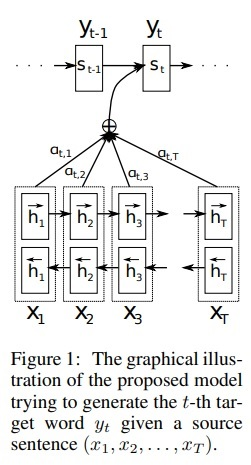

attention 레이어는 지금까지 디코딩한 $s_{t-1}$와 우리가 인코딩한 모든 것 $H$을 취하고 결과로 attention vector, $a_t$를 생성합니다, 
attention 벡터는 소스 문장의 길이이며, 각 요소는 0에서 1 사이이고 전체 벡터의 합은 1입니다. 그리고 다음 디코딩할 단어 $\hat{y}_{t+1}$. 를 정확하게 예측하기 위해 소스 문장에서 어떤 단어에 가장 주의를 기울여야 하는지를 나타냅니다.

본 프로그램에서 
- 에너지 $E_t$ 계산
 - 1. 이전 디코더 hidden state $s_{t-1}$와 인코더 hidden states $H$ 사이의의 energy라고 정의한  값을 계산합니다. 인코더 $H$는 $T$ 텐서의 시퀀스이고, 이전 디코더 $s_{t-1}$는 단일 텐서이므로, 가장 먼저 하는 일은 이전 디코더 $s_{t-1}$ $T$ 번 반복합니다. 
 - 2. 1의 텐서들을 서로 연결하고 a linear layer (`attn`) 와 활성화 함수 $\tanh$ 를 통해 $E_t$를 계산합니다, 

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$ 
 
  - 각 인코더 숨겨진 상태가 이전 디코더 숨겨진 상태와 얼마나 잘 "일치"하는지를 계산하는 것으로 생각할 수 있습니다 

- 각 예제에 **[dec hid dim, src len]** 텐서가 사용됩니다. 소스 문장의 길이에 주목해야 하므로 배치의 각 예제에 대해 [src len]이 되기를 원합니다. 이는 energy  [1, dec hid dim] 텐서($v$)를 곱하면 달성됩니다, 

$$\hat{a}_t = v E_t$$

 - $v$는 모든 인코더 hidden states $H$의의 energy 합계에 가중치를 부여하는 가중치라고 생각할 수 있습니다. 이 가중치는 소스 시퀀스에서 각 토큰에 얼마나 많은 주의를 기울여야 하는지를 알려줍니다. $v$ 매개변수는 랜담으로로 초기화되지만, 나머지 모델과 함께 역전파를 통해 학습됩니다. $v$는 time-step에 의존하지 않으며, 디코딩의 각 time-step마다 동일한 값이이 사용된다는 점에 유의하세요. $v$를 바이어스 없는 선형 레이어로 구현합니다.

- 마지막으로, attention vector는는 모든 요소가 0과 1 사이에 있어야 하고 벡터가 1로 합산되어야 한다는 제약 조건에 부합하는지 확인 후 $\text{softmax}$ 레이어를 거칩니다.

$$a_t = \text{softmax}(\hat{a_t})$$

이렇게 하면 소스 문장에 대한 the attention이이 부여됩니다! 

그래픽으로 보면 아래와 같이 보입니다. 이것은 첫 번째 관심도 벡터를 계산하기 위한 것으로, 여기서 $s_{t-1} = s_0 = z$가 됩니다. 녹색/청록색 블록은 전방향 및 후방향 RNN의 숨겨진 상태를 나타내며, 주의도 계산은 모두 분홍색 블록 내에서 수행됩니다.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq9.png?raw=1)



In [20]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()

        '''self.attn과 self.v는 논문에서 alignment model a (s_i-1, h_j)에 해당하는 fully connected layer이다. 
           annotation h_j와 디코더의 이전 hidden state s_i-1을 사용하여 annotation의 가중치 alpha를 계산하는 역할이다.'''                  
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]       
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        '''(논문의 notation을 따름)
           모든 k에 대해 energy e_ik를 계산하고 결과적으로 alpha_ij를 구하기 위해
           디코더의 이전 time step의 hidden state, s_i-1, 에 해당하는 hidden을 
           src_len(입력 시퀀스의 길이, 논문에서의 T_x)만큼 복제한다.
        '''

        #print("Attention hidden : ", hidden.shape)   
        #print(hidden)        

        '''unsqueeze(1) 메서드를 사용하여 이전 디코더의 hidden 텐서의 차원을 (batch_size, 1, hidden_size)로 늘립니다
           repeat(1, src_len, 1) 메서드는 hidden 텐서를 (1, src_len, hidden_size) 크기로 복제합니다.
        ''' 
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        #print("Attention hidden, unsqueeze, repeat: ", hidden.shape)   
        #print(hidden)         
        #hidden = [batch size, src len, dec hid dim]
 
        '''encoder_outputs는 인코더의 모든 time step에서의 hidden states이다.'''       
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, enc hid dim * 2]       
        #print("Attention encoder_outputs : ", encoder_outputs.shape)
        
        ''' Et=tanh(attn(st−1,H))
            torch.cat : hidden (디코더의 현재 은닉 상태(hidden state)), encoder_outputs(인코더에서 나온 전체 시퀀스의 출력)을  차원 2(src len)를 기준으로 합칩니다. 
            결과적으로 energy는 (batch_size, sequence_length, hidden_size*2)의 크기를 갖습니다.
            
            torch.tanh : energy 텐서의 모든 요소에 대해 하이퍼볼릭 탄젠트(tanh)를 적용합니다. 
            비선형성(nonlinearity)을 추가하여 텐서의 값을 제한하고 다음 단계에서의 어텐션 분포(attention distribution)를 계산하기 위해 수행
            energy는 (-1, 1) 사이의 값을 가지는 텐서입니다.
        '''
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        #energy = [batch size, src len, dec hid dim]
        #print("Attention energy")
        #print("Attention shape : ", energy.shape)
        #print(energy)

        '''a^t=vEt
           self.v : 어텐션 층에서 사용되는 가중치 텐서(weight tensor)를 나타내는 모듈
           self.v(energy) : energy와 곱해지는 가중치 v를 곱하여 어텐션 스코어(attention scores)를 계산,
                            (batch_size, sequence_length, attn_size) 크기의 텐서
           squeeze(2) 메서드는 마지막 차원의 크기가 1인 경우, 해당 차원을 제거합니다. 
                      attn_size 차원이 제거되어 (batch_size, sequence_length) 크기의 텐서
           
           self.v(energy).squeeze(2) : 어텐션 스코어(attention scores)를 계산하여 어텐션 분포(attention distribution)를 나타내는 (batch_size, sequence_length) 크기의 텐서를 반환
        '''
        attention = self.v(energy).squeeze(2)
        #attention= [batch size, src len]
        #print("Attention attention")
        #print("Attention shape : ", attention.shape)
        #print(attention)

        '''입력된 attention 텐서의 각 행(row)에 대해 softmax 함수를 계산합니다. 
           이렇게 계산된 softmax 값은 각 위치의 입력 시퀀스에 대한 어텐션 가중치(attention weights)입니다. 
           softmax 함수를 사용하면 확률(probability) 분포로 변환하여 출력값이 항상 0과 1 사이에 있으며, 모든 출력값의 합이 1이 됩니다. 

           입력된 어텐션 스코어(attention scores)를 softmax 함수를 사용하여 각 위치에 대한 어텐션 가중치(attention weights)로 변환
           반환 텐서는 (batch_size, sequence_length) 크기를 가지며, 모든 위치에 대한 어텐션 가중치는 0과 1 사이에 있으며, 합이 1입니다
        ''' 
        return F.softmax(attention, dim=1)

## Attention Tensor

###1.디코더의 이전 time step의 hidden state $s_{t-1}$
- 1.1 처음 hidden 텐서
 - hidden = [batch size, dec hid dim]
 - Attention hidden :  torch.Size([1, 512])
tensor([[-0.9791,  0.8421, -0.4314,  0.9836, -0.9058,  0.5471, -0.6603,  0.2274,-0.0515, -0.9926,  0.9050, -0.7408,  0.6730, -0.1595, -0.7639,  0.6760, ...

- 1.2 hidden 텐서 조정 : hidden.unsqueeze(1).repeat(1, src_len, 1) 
 - hidden = [batch size, src len, dec hid dim]
 - unsqueeze(1) 메서드를 사용하여 이전 디코더의 hidden 텐서의 차원을 (batch_size, 1, hidden_size)로 늘립니다. 
repeat(1, src_len, 1) 메서드는 hidden 텐서를 (1, src_len, hidden_size) 크기로 복제
 - Attention hidden, unsqueeze, repeat: torch.Size([1, 10, 512])

tensor([[[-0.9791,  0.8421, -0.4314,  ..., -0.9970, -0.8353, -0.7055],
         [-0.9791,  0.8421, -0.4314,  ..., -0.9970, -0.8353, -0.7055],
         [-0.9791,  0.8421, -0.4314,  ..., -0.9970, -0.8353, -0.7055],
         ...,
         [-0.9791,  0.8421, -0.4314,  ..., -0.9970, -0.8353, -0.7055],
         [-0.9791,  0.8421, -0.4314,  ..., -0.9970, -0.8353, -0.7055],
         [-0.9791,  0.8421, -0.4314,  ..., -0.9970, -0.8353, -0.7055]]],
       device='cuda:0')

###2.인코더 결과 : 인코더 hidden states  $H$ 
- 1.1 인코더 텐서 조정 : encoder_outputs.permute(1, 0, 2)
 - 처음 : encoder_outputs = [src len, batch size, enc hid dim * 2] 
 - permute 후 : encoder_outputs = [batch size, src len, enc hid dim * 2]
  
Attention encoder_outputs :  torch.Size([1, 10, 1024])

###3.에너지 energy : 수식 - $Et=tanh(attn(s_{t-1},H))$
- energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2)))

 - torch.cat : hidden (디코더의 현재 은닉 상태(hidden state)), encoder_outputs(인코더에서 나온 전체 시퀀스의 출력)을  차원 2(src len)를 기준으로 합칩니다 . 결과적으로 energy는 [batch size, src len, dec hid dim]의 크기를 갖습니다.
 - torch.tanh : energy 텐서의 모든 요소에 대해 하이퍼볼릭 탄젠트(tanh)를 적용합니다. energy는 (-1, 1) 사이의 값을 가지는 텐서가 되고 다음 단계에서 어텐션 가중치(attention weights)를 계산하는 데 사용.

- Attention shape : torch.Size([1, 10, 512])

tensor([[[-0.9499, -0.1304, -0.0921,  ...,  0.9312,  0.5066, -0.3117],
         [-0.9380, -0.4677,  0.6787,  ...,  0.4881,  0.2216, -0.8938],
         [-0.8439, -0.4846,  0.2655,  ...,  0.9393,  0.2896, -0.3712],
         ...,
         [-0.9946,  0.2483, -0.6345,  ...,  0.9392,  0.7807,  0.3858],
         [-0.9911,  0.1237, -0.6163,  ...,  0.9477,  0.7227,  0.4159],
         [-0.9923,  0.1881, -0.7247,  ...,  0.9623,  0.7508,  0.5857]]],
       device='cuda:0')

###4.attention vector : 수식 - $a^t=vEt$
- attention = self.v(energy).squeeze(2)
 - self.v : 어텐션 층에서 사용되는 가중치 텐서(weight tensor)를 나타내는 모듈   
 - self.v(energy) : energy와 곱해지는 가중치 v를 곱하여 어텐션 스코어(attention scores)를 계산,(batch_size, sequence_length, attn_size) 크기의 텐서
 - squeeze(2) 메서드는 마지막 차원의 크기가 1인 경우, 해당 차원을 제거. attn_size 차원이 제거되어 (batch_size, sequence_length) 크기의 텐서
 - self.v(energy).squeeze(2) : 어텐션 스코어(attention scores)를 계산하여 어텐션 분포(attention distribution)를 나타내는 [batch size, src len] 크기의 텐서를 반환

- Attention shape :  torch.Size([1, 10])
tensor([[ 1.4247, -2.8735, -1.7183,  5.2052,  3.7091,  3.3749,  0.0088,  5.2339,
4.8931,  5.5127]], device='cuda:0')

###5.소프트맥스 적용 : 
- F.softmax(attention, dim=1)
 - 입력된 attention 텐서의 각 행(row)에 대해 softmax 함수를 계산합니다. 이렇게 계산된 softmax 값은 각 위치의 입력 시퀀스에 대한 어텐션 가중치(attention weights)입니다. softmax 함수를 사용하면 확률(probability) 분포로 변환하여 출력값이 항상 0과 1 사이에 있으며, 모든 출력값의 합이 1이 됩니다. 입력된 어텐션 스코어(attention scores)를 softmax 함수를 사용하여 각 위치에 대한 어텐션 가중치(attention weights)로 변환
 - 반환 텐서는 [batch size, src len] 크기를 가지며, 모든 위치에 대한 어텐션 가중치는 0과 1 사이에 있으며, 합이 1입니다
 - attention shape :  torch.Size([1, 10])
 
tensor([[5.0301e-03, 6.8376e-05, 2.1707e-04, 2.2050e-01, 4.9392e-02, 3.5361e-02,
         1.2209e-03, 2.2692e-01, 1.6139e-01, 2.9989e-01]], device='cuda:0')

#**Decoder**

디코더에는 attention vector, $a_t$를 반환하는 attention layer가 포함되어 있습니다. 이 attention vector, $a_t$와  인코더 hidden states, $H$의 가중치 합인 가중치로로 weighted source vector, $w_t$를 생성합니다.

$$w_t = a_t H$$

임베디드 입력 단어, $d(y_t)$, weighted source vector, $w_t$, 전의 디코더 hidden state, $s_{t-1}$로 the decoder RNN를 수행합니다.

$$s_t = \text{DecoderGRU}(d(y_t), w_t, s_{t-1})$$

이후 $d(y_t)$, $w_t$ and $s_t$ 가 선형함수 $f$를 거쳐 다음 목표 예상 단어인 $\hat{y}_{t+1}$를 예측합니다. 이것은 모두 함께 연결하여 수행됩니다.

$$\hat{y}_{t+1} = f(d(y_t), w_t, s_t)$$




아래 이미지는 번역 예제에서 첫 번째 단어를 디코딩하는 모습을 보여줍니다.
![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq10.png?raw=1)

녹색/청록색 블록은 $H$를 출력하는 포워드/워드 인코더 RNN

레드 블록은 context vector z, $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$,

파란색 블록은 결과가 $s_t$인 the decoder RNN

보라색 블록은 결과가 $\hat{y}_{t+1}$ 인 선형 레이어 ,$f$

주황 블록은 $w_t = a_t H$를 계산한 결과입니다.
($a_t$ 표시되지 않습니다.)

In [21]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        #output_dim은 인코더의 input_dim과 마찬가지로 타겟 언어의 토큰 종류 수를 의미한다.
        #   (target vocabulary의 길이)
        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #print("Decoder input")
        #print("Decoder shape : ", input.shape)
        #print(input)

        #input = [1, batch size]
        '''input은 디코더가 이전 time step에서 예측한 단어인 y_i-1 에 해당한다.
           임베딩된 벡터를 RNN에 집어넣으려면 (1, batch size, emb dim)의 차원으로 만들어야 하기 때문에
           임베딩 이전에 unsqueeze 함수를 사용해 차원을 아래 주석처럼 변경한다.'''                
        input = input.unsqueeze(0)   
        #print("Decoder input after unsqueeze(0)")
        #print("Decoder shape : ", input.shape)
        #print(input)

        '''임베딩하고 드롭아웃을 적용한다.'''
        embedded = self.dropout(self.embedding(input))      
        #embedded = [1, batch size, emb dim]
        #print("Decoder embedded")
        #print("Decoder shape : ", embedded.shape)
        #print(embedded)

        '''여기서 hidden은 디코더의 이전 time step에서의 hidden state에 해당한다.
           encoder_outputs는 인코더 클래스의 output(모든 time step에서의 hidden states)에 해당한다.
           hidden과 encoder_outputs, 어텐션 레이어를 사용해 a를 계산하는데 여기서 a는 논문에서의 alpha_ij에 해당한다.'''       
        a = self.attention(hidden, encoder_outputs)               
        #a = [batch size, src len]
        #print("a")
        #print("attention shape : ", a.shape)
        #print(a)

        a = a.unsqueeze(1)

        #a = [batch size, 1, src len]   
        #print("Decoder a after unsqueeze(1)")
        #print("Decoder shape : ", a.shape)
        #print(a)
        
        ''' Tensor의 shape은 (sequence_length, batch_size, hidden_size)입니다. 
            permute 메서드는 PyTorch Tensor의 차원 순서를 재배열하는 메서드입니다. 
            이 경우 encoder_outputs.permute(1, 0, 2)는 encoder_outputs Tensor의 차원 순서를 (batch_size, sequence_length, hidden_size)으로 바꿔줍니다.
        '''
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        ''' a는 (batch_size, output_seq_len, hidden_size) 모양의 3D Tensor
            encoder_outputs는 (batch_size, input_seq_len, hidden_size) 모양의 3D Tensor
            따라서, a와 encoder_outputs는 모두 배치 크기(batch size)가 존재하는 3D Tensor입니다.

            torch.bmm 함수는 두 개의 배치 매트릭스를 곱하여 새로운 배치 매트릭스를 반환합니다. 
            이 함수를 사용하면 a와 encoder_outputs의 매트릭스 곱 결과인 (batch_size, output_seq_len, input_seq_len) 모양의 3D Tensor가 생성됩니다. 
            이 3D Tensor의 각 원소는 a와 encoder_outputs의 각 시점에서의 내적(dot product) 값을 나타냅니다.        
        '''
        weighted = torch.bmm(a, encoder_outputs)
        #print("Decoder weighted")
        #print("Decoder shape : ", weighted.shape)
        #print(weighted)

        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        '''rnn_input은 embedded(y_i-1)와 weighted(c_i)를 concatenate한 것이다.
           torch.cat 함수를 사용하여 차원 2(batch size)를 기준으로 합칩니다.
        '''       
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]

        '''hidden은 디코더 RNN의 이전 hidden state에 해당하고 rnn_input은 y_i-1과 c_i에 해당한다.
           이전 hidden state와 이전에 예측한 단어, context vector를 사용하여 현재 디코더 RNN hidden state s_i를 계산하는 연산이다.
           한 단어씩 예측하고 있으므로 예측하는 시퀀스의 길이인 sequence length는 1이고, 따라서 output과 hidden은 같은 값이다.'''           
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #print("Decoder output")
        #print("Decoder shape : ", output.shape)
        #print(output)
        #print("Decoder hidden")
        #print("Decoder shape : ", hidden.shape)
        #print(hidden)

        '''output과 hidden이 완전히 동일한 배열임을 확인하는 것입니다. 만약 두 배열의 요소 중 하나라도 다르면, AssertionError가 발생
        '''
         #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        '''output(현재 디코더 RNN hidden state, s_i)과 weighted(c_i), embedded(y_i-1)을 사용해 현재 단어 y_i를 예측하기 위해 prediction을 계산한다.
           output, weighted, embedded를 concatenate해서 fc_out에 입력하여 얻은 prediction의 차원은 output_dim(target vocabulary length)이다.
           즉, prediction은 target vocabulary에서 각 토큰이 적합한 토큰일 확률을 담고 있는 벡터이고, 논문에서의 조건부확률p(y_i|y_1,...,y_i-1,x)에 해당한다.'''       
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        #print("Decoder prediction")
        #print("Decoder shape : ", prediction.shape)
        #print(prediction)       
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

##Decoder Tensor 
forward(self, input, hidden, encoder_outputs)

###1.Decoder input 조정
- 1.1 최초 input :
   - Decoder shape -  torch.Size([1])
tensor([2], device='cuda:0')
- 1.2 Decoder input after unsqueeze(0) 
   - Decoder shape :  torch.Size([1, 1])
tensor([[2]], device='cuda:0')
- 1.3 Decoder embedding & dropout : embedded = self.dropout(self.embedding(input)) 
 - embedded = [1, batch size, emb dim]
 - Decoder shape :  torch.Size([1, 1, 256])

tensor([[[ 0.1452,  0.0371,  0.1001, -0.1273,  0.1582, -0.0037,  0.1510,
          -0.1329,  0.1279, -0.1405,  0.1384,  0.1456,  0.1487, -0.1129,
           0.1507, -0.0777,  0.1322,  0.1541, -0.1303,  0.0015, -0.1286,

###2.Attenstion 수행
- 2.1 attention 실행 : a = [batch size, src len]
 - a = self.attention(hidden, encoder_outputs) 
attention shape :  torch.Size([1, 10])
 
tensor([[5.0301e-03, 6.8376e-05, 2.1707e-04, 2.2050e-01, 4.9392e-02, 3.5361e-02,
         1.2209e-03, 2.2692e-01, 1.6139e-01, 2.9989e-01]], device='cuda:0')

- 2.2 attection vector unsqueeze : a = [batch size, 1, src len]   
 - Decoder a after unsqueeze(1) : 
Decoder shape :  torch.Size([1, 1, 10])

tensor([[[5.0301e-03, 6.8376e-05, 2.1707e-04, 2.2050e-01, 4.9392e-02,
          3.5361e-02, 1.2209e-03, 2.2692e-01, 1.6139e-01, 2.9989e-01]]],
       device='cuda:0')

###3.encoder_outputs 조정
- encoder_outputs = encoder_outputs.permute(1, 0, 2)
- [src len, batch size, enc hid dim * 2] -> [batch size, src len, enc hid dim * 2]

###4.Decoder weighted source vector, $wt$ 를 생성 : 수식 $wt=atH$
논문에서의 context vector $c_{i}$에 해당
- 4.1 weighted = torch.bmm(a, encoder_outputs)
 - [batch size, 1, enc hid dim * 2]
 - torch.bmm 함수는 두 개의 배치 매트릭스를 곱하여 새로운 배치 매트릭스를 반환합니다. 
 - 이 함수를 사용하면 a와 encoder_outputs의 매트릭스 곱 결과인 (batch_size, output_seq_len, input_seq_len) 모양의 3D Tensor가 생성됩니다. 이 3D Tensor의 각 원소는 a와 encoder_outputs의 각 시점에서의 내적(dot product) 값을 나타냅니다.
 - Decoder shape :  torch.Size([1, 1, 1024])

tensor([[[-0.2032,  0.0560, -0.0486,  ...,  0.0457,  0.0260, -0.0348]]],
       device='cuda:0')

- 4.2 weighted = weighted.permute(1, 0, 2)
 - [1, batch size, enc hid dim * 2]

###5.Decoder RNN 수행 : 수식 $st=DecoderGRU(d(yt),wt,s_{t-1})$
임베디드 입력 단어,  $d(yt)$ , weighted source vector,  $wt$ , 전의 디코더 hidden state,  $s_{t-1}$ 로 the decoder RNN를 수행

- 5.1 rnn_input: input을 임베딩한 embedded과 weighted를 batch_size를 기준으로 concatenate 
 - rnn_input = torch.cat((embedded, weighted), dim = 2)
 - rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
- 5.2 Decoder rnn (GRU) 수행
 - output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
 - Decoder output
   - output = [seq len, batch size, dec hid dim * n directions], = [1, batch size, dec hid dim]
   - Decoder shape :  torch.Size([1, 1, 512])

tensor([[[-0.9716, -0.9459,  0.9376,  0.9981, -0.8825,  0.9470, -0.6601, -0.9821, -0.2298, -0.9925,  0.9473, -0.7488,  0.9892,  0.9775, -0.9785, -0.5117,  0.8771, -0.7815,  0.9928,  0.9897,  0.9755,
 - Decoder hidden
   - hidden = [n layers * n directions, batch size, dec hid dim],
 = [1, batch size, dec hid dim]    
   - Decoder shape :  torch.Size([1, 1, 512])

tensor([[[-0.9716, -0.9459,  0.9376,  0.9981, -0.8825,  0.9470, -0.6601,
          -0.9821, -0.2298, -0.9925,  0.9473, -0.7488,  0.9892,  0.9775,
          -0.9785, -0.5117,  0.8771, -0.7815,  0.9928,  0.9897,  0.9755,

- 5.3 output과 hidden이 완전히 동일한 배열임을 확인
 - assert (output == hidden).all()
  - output과 hidden이 완전히 동일한 배열임을 확인하는 것입니다. 만약 두 배열의 요소 중 하나라도 다르면, AssertionError가 발생

###6.Decoder prediction : 수식 $\hat{y}_{t+1} = f(d(y_t), w_t, s_t)$
임베디드 입력 단어,  $d(yt)$ , weighted source vector,  $wt$ , 현재 디코더 hidden state,$s_t$가 선형함수  f 를 거쳐 다음 목표 예상 단어인 $\hat{y}_{t+1}$ 를 예측
-6.1 prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
 - prediction은 디코더의 hidden state($s_t$)output, context vector인 weighted, 디코더가 이전에 예측한 단어인 embedded를 concatenate해서 fully connected layer에 입력해 얻은 값이다. 
 - 논문에서의 조건부확률p(y_i|y_1,...,y_i-1,x)에 해당
 - prediction = [batch size, output dim]
 - Decoder prediction
   - Decoder shape :  torch.Size([1, 5893])

tensor([[ 1.9313, -3.0029, -2.8065,  ..., -2.1848, -2.1077, -1.9325]],
       device='cuda:0')


#**Seq2Seq**
이 모델은 인코더 RNN과 디코더 RNN의 숨겨진 치수가 같을 필요는 없지만 인코더가 양방향이어야 하는 첫 번째 모델입니다. 이 요구 사항은 enc_dim * 2의 모든 경우를 encoder_is_bidirectional이면 enc_dim * 2로, 그렇지 않으면 enc_dim으로 변경하여 제거할 수 있습니다.

이 seq2seq 인캡슐레이터는 앞의 두 인캡슐레이터와 유사합니다. 유일한 차이점은 인코더가 디코더의 초기 숨겨진 상태로 사용할 최종 숨겨진 상태(선형 레이어를 통과한 순방향 및 역방향 인코더 RNN의 최종 숨겨진 상태)와 모든 숨겨진 상태(순방향 및 역방향 숨겨진 상태가 서로 겹쳐진 상태)를 모두 반환한다는 점입니다. 또한 숨겨진 상태와 encoder_outputs가 디코더로 전달되는지 확인해야 합니다.

모든 단계를 간략히 살펴보겠습니다:

모든 예측을 보유하기 위해 출력 텐서 $\hat{Y}$가 생성되고, 

소스 시퀀스인 $X$가 인코더에 공급되어 $z$와 $H$를 수신합니다. 

초기 디코더 숨겨진 상태는 컨텍스트 벡터,$s_0 = z = h_T$로 설정됩니다. 

첫 번째 입력으로 <sos> 토큰 일괄 처리($y_1$를 사용합니다. 

을 첫 번째 입력으로 사용한 다음 루프 내에서 디코딩합니다:
입력 토큰 $y_t$, 이전 숨겨진 상태인 $s_{t-1}$, 모든 인코더 출력인 $H$를 디코더에 삽입합니다.
예측값인 $\hat{y}_{t+1}$ 과 새로운 숨겨진 상태인 $s_t$를 수신합니다. 
를 수신하는 디코더에 삽입한 다음, 다음 입력을 적절히 설정하여 강제 학습할지 여부를 결정합니다.


In [22]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        '''src는 소스 문장, trg는 타겟 문장에 해당한다 (문장은 토큰의 정수 인덱스의 시퀀스로 표현됨).
           teacher_forcing_ratio는 teacher forcing을 사용할 빈도이다.
           teacher_forcing이 무엇인지는 아래에서 설명한다.'''
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        '''trg_len은 출력 시퀀스의 길이에 해당한다.'''
        trg_len = trg.shape[0]
        '''trg_vocab_size는 target 언어의 토큰 종류 수를 의미한다.'''
        trg_vocab_size = self.decoder.output_dim
        
        '''디코더의 출력(즉, 예측된 토큰의 확률분포의 시퀀스스)을 저장하기 위해 (문장 길이, 배치크기, 타겟 토큰 종류 수) 크기의 텐서를 생성한다.'''
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        '''encoder_outputs는 인코더의 모든 time step에서의 hidden states, hidden은 인코더의 마지막 hidden state를 의미한다.'''
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        '''디코더에 처음 입력되는 토큰은 시퀀스의 시작을 의미하는 '<sos>'으로 하기 위해 input을 trg[0,:]으로 지정한다.'''
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        '''아래 과정을 타겟 문장의 길이(trg_len)만큼 반복한다.'''
        for t in range(1, trg_len):
            
            '''디코더에 input(이전에 예측한 단어, y_i-1, 또는 t=1인 경우 <sos>), 
               hidden(디코더의 이전 hiddenstate, 또는 t=1인 경우 인코더의 마지막 hidden state),
               encoder_outputs(인코더의 모든 timestep에서의 hiddenstates)를 입력하여 
               디코더의 현재 hidden state s_i(output, hidden)를 얻는다.'''            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            '''디코더의 현재 hidden state s_t를 outputs[t]에 저장한다.'''
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output

            '''random.random()은 0과 1 사이의 실수를 uniform distribution에서 샘플링하는 함수이다.
               즉, random.random()은 teacher_forcing_ratio의 확률로 teacher_forcing_ratio보다 작다.
               teacher_force에 teacher force를 시행할지 여부를 boolean으로 저장한다.'''            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio

            '''디코더의 현재 hidden state s_t에 해당하는 output은 target vocabulary의 각 token이 적합한 token일 확률을 담고 있다.
               가장 확률이 높은 토큰의 인덱스를 top1에 저장한다.'''
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 

            '''만일 teacher_force가 true이면 input에 디코더가 이전 timestep에서 예측한 토큰 대신 실제 타겟 토큰인 trg[t]를 사용한다.
               학습 초기에 모델의 성능이 좋지 않을 때, 디코더가 이전에 예측한 단어를 기반으로 현재 단어를 예측하는 것은 무의미한 일일 경우가 많다.
               따라서 학습 속도가 저하될 수 있는데, teacher forcing 기법을 사용하여 일정 확률로 디코더가 예측한 토큰 대신 실제 토큰을 사용하여 다음 토큰을
               예측하도록 함으로써 학습 속도를 높일 수 있다.'''           
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        '''반환되는 outputs는 모든 target time step i에 대해 디코더가 예측한 확률분포의 시퀀스이다.'''

        return outputs

## Training the Seq2Seq Model

논문과는 다르지만 하이퍼파라미터를 정의하고 Attention, 인코더, 디코더 및 seq2seq 모델을 초기화합니다(GPU가 있는 경우 GPU에 배치).

In [23]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

여기서는 논문에서 사용된 가중치 초기화 체계의 단순화된 버전을 사용합니다. 여기서는 모든 바이어스를 0으로 초기화하고 모든 가중치를 $\mathcal{N}(0, 0.01)$ 에서 초기화합니다.


In [24]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

매개변수 수를 계산합니다.

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,518,405 trainable parameters


Adam optimizer(학습률을 적응적으로 조절하여, 각 매개변수에 대해 다른 학습률을 적용할 수 있습니다)를 사용하여 모델의 매개변수를 최적화합니다.

In [26]:
optimizer = optim.Adam(model.parameters())

We initialize the loss function.

In [27]:
'''  입력 문장과 출력 문장의 길이가 다를 수 있다. 
     이때 입력 문장과 출력 문장의 최대 길이를 정하고, 모든 문장을 해당 길이에 맞게 패딩하여 입력 데이터와 출력 데이터를 구성하며 
     이때 패딩 토큰에 해당하는 정수값을 반환한다.
'''     
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

''' ignore_index = TRG_PAD_IDX : Cross Entropy Loss를 정의할 때, 출력 데이터의 패딩 토큰을 무시하도록 설정
    Cross Entropy Loss는 분류 문제에서 모델이 예측한 출력값과 정답 클래스를 비교하여 손실 값을 계산하는 손실 함수
'''
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

We then create the training loop...

In [28]:
def train(model, iterator, optimizer, criterion, clip):
    
    '''오차역전파를 위한 기울기(gradient)가 계산되도록 model.train()을 사용한다.
       model.train() 모델을 학습 모드로 전환하여 드롭아웃이나 배치 정규화 등의 모듈이 학습 상태로 변경한다.
    '''
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        '''옵티마이저의 gradient를 0으로 초기화한다.'''        
        optimizer.zero_grad()
        '''output은 모델이 예측한 y_i에 대한 확률분포의 시퀀스이다.'''       
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        '''output의 shape는 (batch의 총 토큰 수, target vocabulary의 토큰 수) 이다.'''      
        output = output[1:].view(-1, output_dim)
        #print(output.shape)
        #print(output)
        '''trg의 shape는 (batch의 총 토큰 수)이다. trg는 확률분포가 아닌 정수 인덱스의 시퀀스이기 때문에 크기가 1차원이다.'''
        trg = trg[1:].view(-1)
        #print(trg.shape)
        #print(trg)

        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        '''cross entropy loss를 계산'''       
        loss = criterion(output, trg)
        '''loss.backward()로 gradient 계산'''       
        loss.backward()
        '''안정적인 학습을 위해 gradient clipping 수행'''        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        '''오차역전파 수행'''       
        optimizer.step()
        '''해당 epoch의 총 loss를 확인하기 위해 loss를 더함'''       
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

the evaluation loop

In [29]:
def evaluate(model, iterator, criterion):
    
    ''' 모델을 추론 모드로 전환하여 드롭아웃이나 배치 정규화 등의 모듈이 추론 상태로 변경
    '''
    model.eval()
    
    epoch_loss = 0
    
    ''' 그 아래에 있는 코드는 자동 미분(매개변수에 대한 손실(loss)의 미분값(gradient)을 자동으로 계산하여 매개변수를 업데이트하는 것)을 수행하지 않는다.
       이를 통해 메모리와 연산 비용을 줄일 수 있다.
    '''  
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            '''train() 함수에서 했던  gradient 계산과 오차 역전파를 위한 코드가 제외되었다.
            '''
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

1 epoch를 학습하는데 필요한 시간을 측정하는 함수를 정의합니다.

In [30]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

모델을 학습시켜 유효성 검사 손실이 가장 적은 매개변수를 저장합니다


학습할 epoch인 N_EPOCHS를 정의하고 gradient clipping을 위한 하이퍼파라미터 지정합니다. 
학습과 검증을 N_EPOCHS만큼 수행하며 학습 loss와 검증 loss를 매 epoch 출력합니다..

In [31]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 25s
	Train Loss: 5.020 | Train PPL: 151.383
	 Val. Loss: 4.810 |  Val. PPL: 122.766
Epoch: 02 | Time: 1m 29s
	Train Loss: 4.127 | Train PPL:  61.996
	 Val. Loss: 4.605 |  Val. PPL:  99.934
Epoch: 03 | Time: 1m 29s
	Train Loss: 3.471 | Train PPL:  32.183
	 Val. Loss: 3.754 |  Val. PPL:  42.686
Epoch: 04 | Time: 1m 30s
	Train Loss: 2.916 | Train PPL:  18.472
	 Val. Loss: 3.420 |  Val. PPL:  30.574
Epoch: 05 | Time: 1m 30s
	Train Loss: 2.521 | Train PPL:  12.437
	 Val. Loss: 3.316 |  Val. PPL:  27.562
Epoch: 06 | Time: 1m 30s
	Train Loss: 2.236 | Train PPL:   9.357
	 Val. Loss: 3.241 |  Val. PPL:  25.563
Epoch: 07 | Time: 1m 30s
	Train Loss: 1.994 | Train PPL:   7.348
	 Val. Loss: 3.153 |  Val. PPL:  23.396
Epoch: 08 | Time: 1m 29s
	Train Loss: 1.776 | Train PPL:   5.908
	 Val. Loss: 3.189 |  Val. PPL:  24.258
Epoch: 09 | Time: 1m 29s
	Train Loss: 1.603 | Train PPL:   4.967
	 Val. Loss: 3.233 |  Val. PPL:  25.363
Epoch: 10 | Time: 1m 29s
	Train Loss: 1.492 | Train PPL

검증 데이터에 대해 가장 높은 성능을 보인 모델을 불러온다.
불러온 모델을 사용해 테스트 데이터에 대해 loss와 perplexity를 계산하여 출력한다.

In [32]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.171 | Test PPL:  23.822 |



## 번역모델 확인
학습된 모델이 독일어-영어 번역을 잘 하는지 translate()함수 정의하고 테스트 데이터의 문장을 사용했다.

In [33]:
def translate(model, iterator):
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            '''배치의 첫 데이터만을 사용
               vocabulary에서 token의 index로부터 단어를 찾아 출력'''
            if i == 1:
                break
            src = batch.src
            trg = batch.trg
            src, trg = src[:,0], trg[:,0]
            print("Source sentence")
            for token in src:
                print(SRC.vocab.itos[token])
            print("\nTarget sentence")
            for token in trg:
                print(TRG.vocab.itos[token])

            src, trg = src.reshape(-1, 1), trg.reshape(-1, 1)
            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            output = output.argmax(dim=1)
            print("\nTranslated sentence")
            for token in output:
                print(TRG.vocab.itos[token])
                trg_tokens = TRG.vocab.itos[token]

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]


In [34]:
translate(model, test_iterator)

Source sentence
<sos>
zwei
mittelgroße
hunde
laufen
über
den
schnee
.
<eos>

Target sentence
<sos>
two
medium
sized
dogs
run
across
the
snow
.
<eos>
<pad>
<pad>
<pad>

Translated sentence
two
steeplechase
-
war
dogs
dogs
running
across
the
snow
.
<eos>
<eos>


#1.EPOCH 1일 경우

## train
Epoch: 01 | Time: 8m 1s
	Train Loss: 5.020 | Train PPL: 151.390
	 Val. Loss: 4.814 |  Val. PPL: 123.247

## evaluation 후 최적의 loss와 perplexity
| Test Loss: 4.805 | Test PPL: 122.059 |   

## 번역 결과
- Source sentence :
<sos>
zwei
mittelgroße
hunde
laufen
über
den
schnee
.
<eos>

- Target sentence :
<sos>
two
medium
sized
dogs
run
across
the
snow
.
<eos>

- Translated sentence :
<sos>
two
men
are
are
the
street
.

#2.EPOCH 10일 경우

## train : Epoch: 07 번째가 최적화
Epoch: 01 | Time: 1m 25s
	Train Loss: 5.020 | Train PPL: 151.383
	 Val. Loss: 4.810 |  Val. PPL: 122.766

Epoch: 02 | Time: 1m 29s
	Train Loss: 4.127 | Train PPL:  61.996
	 Val. Loss: 4.605 |  Val. PPL:  99.934
...

**Epoch: 07 | Time: 1m 30s
	Train Loss: 1.994 | Train PPL:   7.348
	 Val. Loss: 3.153 |  Val. PPL:  23.396 **

Epoch: 08 | Time: 1m 29s
	Train Loss: 1.776 | Train PPL:   5.908
	 Val. Loss: 3.189 |  Val. PPL:  24.258

Epoch: 09 | Time: 1m 29s
	Train Loss: 1.603 | Train PPL:   4.967
	 Val. Loss: 3.233 |  Val. PPL:  25.363

Epoch: 10 | Time: 1m 29s
	Train Loss: 1.492 | Train PPL:   4.444
	 Val. Loss: 3.285 |  Val. PPL:  26.709

## evaluation 후 최적의 loss와 perplexity
| Test Loss: 3.171 | Test PPL:  23.822 |  

## 번역 결과
- Source sentence :
<sos>
zwei
mittelgroße
hunde
laufen
über
den
schnee
.
<eos>

- Target sentence :
<sos>
two
medium
sized
dogs
run
across
the
snow
.
<eos>
<pad>
<pad>
<pad>

- Translated sentence :
<sos>
two
steeplechase
 -
war
dogs
dogs
running
across
the
snow
.
<eos>
<eos>